In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
from scipy import sparse
import json
from tqdm import tqdm, tqdm_notebook
import os

%run ../Scripts/coverage.py
%run ../Scripts/fitness.py
%run ../Scripts/immunity.py
%run ../Scripts/initMethods.py
%run ../Scripts/supMethods.py
%run ../Scripts/mutation.py
%run ../Scripts/altImmunity.py

In [2]:
params = { #parameters relevant for the equations
    "Nh":             1E8,
    "N0":             1E7, #This Will be updated by self-consitent solution
    "R0":              20, 
    "M":                1, #Also L, total number of spacers
    "mu":            0.01, #mutation rate
    "gamma_shape":     20, 
    "Np":               0, #Number of Cas Protein
    "dc":               3, #Required number of complexes to activate defence
    "h":                4, #coordination coeff
    "r":             2000, #cross-reactivity kernel
    "beta":        -0.001,
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                   1000,
    "dx":                           1,
    "tf":                        2000,
    "dt":                           1,
    "initial_mean_n":           [0,0],
    "initial_mean_nh":          [0,0],
    "conv_size":                 4000,
    "num_threads":                 32,
    "tail_axis":               [1, 1],
}

In [3]:
params, sim_params = init_cond(params, sim_params)

i = 7
foldername = f"../Data/test{i}"
while os.path.exists(foldername):
    i += 1
    foldername = f"../Data/test{i}"

try:
    write2json(foldername, params, sim_params)
except FileNotFoundError:
    os.mkdir(foldername)
    write2json(foldername, params, sim_params)


Phage Population: 10000000.0000| Uc: 10.9541| sigma: 2.6380
Phage Population: 62805.4977| Uc: 7.4325| sigma: 2.3942
Phage Population: 51734.3430| Uc: 7.2822| sigma: 2.3820
Phage Population: 51208.5059| Uc: 7.2743| sigma: 2.3814
Phage Population: 51180.5029| Uc: 7.2738| sigma: 2.3813
Phage Population: 51179.0027| Uc: 7.2738| sigma: 2.3813
Phage Population: 51178.9223| Uc: 7.2738| sigma: 2.3813


In [ ]:
n = init_guassian(params["N"], sim_params, "n")
nh = init_exptail(params["Nh"], params, sim_params, "nh")
kernel_quarter = init_quarter_kernel(params, sim_params)
kernel_exp = init_quarter_kernel(params, sim_params, type="Boltzmann")

for i in range(sim_params["tf"]):
    sparse.save_npz(foldername+f"/sp_frame_n{i}",n.tocoo())
    sparse.save_npz(foldername+f"/sp_frame_nh{i}",nh.tocoo())

    p = elementwise_coverage(nh, n, kernel_quarter, params, sim_params)
    f = fitness_spacers(n, nh, p, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
    f = norm_fitness(f, n, params, sim_params) #renormalize f
    n = virus_growth(n, f, params, sim_params) #update

    n = mutation(n, params, sim_params)
    nh_gain = immunity_gain_from_kernel(nh, n, kernel_exp, params, sim_params) #update nh
    nh = immunity_loss_uniform(nh_gain, n, params, sim_params)

In [25]:
foldername = "../Data/test13"
with open(foldername + "/params.json") as json_file:
    params = json.load(json_file)
with open(foldername + "/sim_params.json") as json_file:
    sim_params = json.load(json_file)

i = 999
kernel_quarter = init_quarter_kernel(params, sim_params)

n = sparse.load_npz(foldername+f"/sp_frame_n{i}.npz").todok()
nh = sparse.load_npz(foldername+f"/sp_frame_nh{i}.npz").todok()

In [26]:
p = elementwise_coverage(nh, n, kernel_quarter, params, sim_params)
f = fitness_spacers(n, nh, p, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
f = norm_fitness(f, n, params, sim_params)

elementwise_coverage took 00:00:37


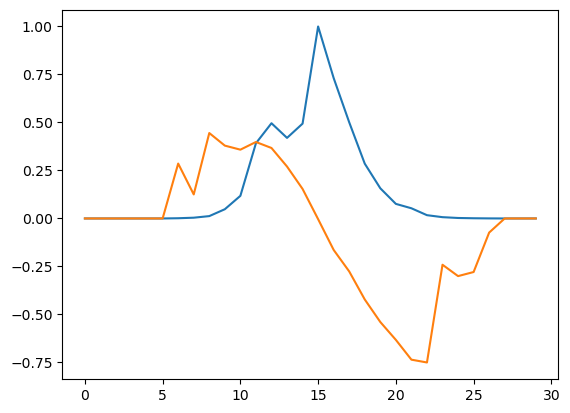

In [42]:
plt.figure()
foldername = "../Data/test13"
i = 999
n = sparse.load_npz(foldername+f"/sp_frame_n{i}.npz")
n_squash = np.sum(n.toarray(), axis = 0)[930:960]
plt.plot(minmax_norm(n_squash))
f_squash = np.sum(f.toarray(), axis = 0)[930:960]
plt.plot(f_squash)

In [ ]:
R0_sweep = [20]
kernel = init_quarter_kernel(params, sim_params)
foldername = "test0/"
write2json(foldername, params, sim_params)

for R0 in R0_sweep:
    params["R0"] = R0
    n = init_guassian(params["N"], sim_params, "n")
    nh = init_guassian(params["Nh"], sim_params, "nh")

    for i in range(10000):

        if (i%100 == 0 or i < 20):
            sparse.save_npz(foldername+f"/sp_frame_n{i}",n.tocoo())
            sparse.save_npz(foldername+f"/sp_frame_nh{i}",nh.tocoo())

        p = elementwise_coverage(nh, n, kernel, params, sim_params)
        f = fitness_spacers(n, nh, p, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
        # f = norm_fitness(f, n, params, sim_params)
        n = virus_growth(n, f, params, sim_params) #update

        n = mutation(n, params, sim_params)
        nh = immunity_update(nh, n, params, sim_params) #update nh

        if np.sum(n) >= 10*params["Nh"]:
            break